# ME5413 Homework 3: Planning

## Task 0: Load the Map

In [1]:
import numpy as np
import imageio as imageio
import matplotlib.pyplot as plt
import time
import pandas as pd
%matplotlib inline

Size of the map: (1000, 1000)
Occupied Cells: 823039
Free Cells: 176961


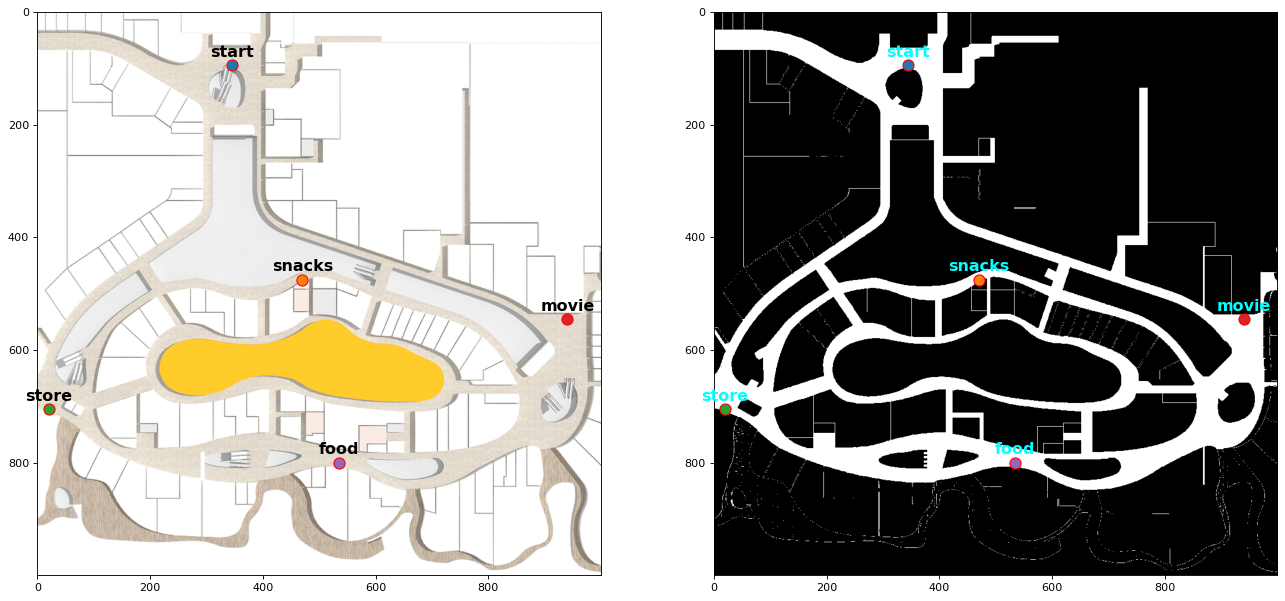

Cell start is free: True
Cell snacks is free: True
Cell store is free: True
Cell movie is free: True
Cell food is free: True


In [2]:
# Load the map
floor_plan = imageio.imread('./map/vivocity.png')
grid_map_img = imageio.imread('./map/vivocity_freespace.png')
grid_map = grid_map_img.transpose()
print("Size of the map:", grid_map.shape)
print("Occupied Cells:", np.count_nonzero(grid_map == 0))
print("Free Cells:", np.count_nonzero(grid_map == 255))

# Map resolution (Constant)
MAP_RES = 0.2 # each cell represents a 0.2m x 0.2m square in reality

# Locations on the map
locations = {'start':  [345, 95],    # Start from the level 2 Escalator
             'snacks': [470, 475],   # Garrett Popcorn
             'store':  [20, 705],    # DJI Store
             'movie':  [940, 545],   # Golden Village
             'food':   [535, 800],   # PUTIEN
            }

# A helper function to mark the locations on the map
def plot_locations(locations: dict, color: 'str'='black'):
    for key, value in locations.items():
        plt.plot(locations[key][0], locations[key][1], marker="o", markersize=10, markeredgecolor="red")
        plt.text(locations[key][0], locations[key][1]-15, s=key, fontsize='x-large', fontweight='bold', c=color, ha='center')
    return

# Plot the locaitons on the map 
plt.figure(figsize=(20, 10), dpi=80)
plt.subplot(1,2,1)
plt.imshow(floor_plan)
plot_locations(locations)
plt.subplot(1,2,2)
plt.imshow(grid_map_img, cmap='gray')
plot_locations(locations, color='cyan')
plt.show()

# Check if the designated locations are free
for key, value in locations.items():
    print(f"Cell {key} is free: {grid_map[value[0], value[1]] == 255}")

# Task 1

## 1.1 Implement A*

The size of each grid is 0.2m; when moving between neighboring grids, the moving distance is 0.2m; when moving diagonal grids, the moving distance is 0.282m;.
According to the constraints, no obstacles are allowed within 0.3m radius of the grid that can be moved. That is, all 8 neighbors of this grid must be free of obstacles

### 1.1.1 Normal Astar without regard to step limits

In [25]:
def heuristic_function(start, goal):
    return np.sqrt((start[0] - goal[0]) ** 2 + (start[1] - goal[1]) ** 2) * MAP_RES

def get_cost(dx, dy):
    if dx == 0 or dy == 0: 
        return 0.2
    else:
        return 0.282

def reconstruct_path(came_from, current):
    total_path = [current]
    distance = 0
    while current in came_from:
        current = came_from[current]
        distance += get_cost(total_path[-1][0] - current[0], total_path[-1][1] - current[1])
        total_path.append(current)
    return total_path, distance

def visualize_path(path_array, map_img, map_locations):
    plt.figure(figsize=(8, 8))
    plt.imshow(map_img, cmap='gray')
    plot_locations(map_locations, color='blue')
    if path_array:
        x, y = zip(*path_array)
        plt.plot(x, y, marker='o', color='red', markersize=1, linestyle='-')
    plt.show()
    
def get_neighbour(node, map_data, labeled_map):
    dirs = [(0, 1), (0, -1), (1, 0), (-1, 0), (1, 1), (1, -1), (-1, 1), (-1, -1)]
    result = []
    for dir in dirs:
        neighbor = (node[0] + dir[0], node[1] + dir[1])
        if labeled_map[neighbor[0], neighbor[1]] == 0:          # 0 means have obstacle nearby
            continue
        elif labeled_map[neighbor[0], neighbor[1]] == 1:
            result.append(neighbor)                             # 1 means have been checked no obstacle nearby
            continue
    
        if 0 <= neighbor[0] < map_data.shape[0] and 0 <= neighbor[1] < map_data.shape[1] and map_data[neighbor[0], neighbor[1]] == 255:
            
            # Check if all 8-connected neighbors of the neighbor are reachable
            all_neighbors_reachable = True
            for dir2 in dirs:
                neighbor2 = (neighbor[0] + dir2[0], neighbor[1] + dir2[1])
                if not (0 <= neighbor2[0] < map_data.shape[0] and 0 <= neighbor2[1] < map_data.shape[1] and map_data[neighbor2[0], neighbor2[1]] == 255):
                    all_neighbors_reachable = False
                    labeled_map[neighbor[0], neighbor[1]] = 0   # 0 means have obstacle nearby
                    break
                    
            if all_neighbors_reachable:
                result.append(neighbor)
                labeled_map[neighbor[0], neighbor[1]] = 1       # 1 means have been checked no obstacle nearby
                
    return result

# def get_neighbour(node, map_data, labeled_map):
#     dirs = [(0, 1), (0, -1), (1, 0), (-1, 0), (1, 1), (1, -1), (-1, 1), (-1, -1)]
#     result = []
#     for dir in dirs:
#         neighbor = (node[0] + dir[0], node[1] + dir[1])
#         if 0 <= neighbor[0] < map_data.shape[0] and 0 <= neighbor[1] < map_data.shape[1] and map_data[neighbor[0], neighbor[1]] == 255:
#             # Check if all 8-connected neighbors of the neighbor are reachable
#             all_neighbors_reachable = True
#             for dir2 in dirs:
#                 neighbor2 = (neighbor[0] + dir2[0], neighbor[1] + dir2[1])
#                 if not (0 <= neighbor2[0] < map_data.shape[0] and 0 <= neighbor2[1] < map_data.shape[1] and map_data[neighbor2[0], neighbor2[1]] == 255):
#                     all_neighbors_reachable = False
#                     break
#             if all_neighbors_reachable:
#                 result.append(neighbor)
#     return result

Run Time: 2.9990689754486084 seconds
Path steps is 631, Distance is: 142.31800000000007


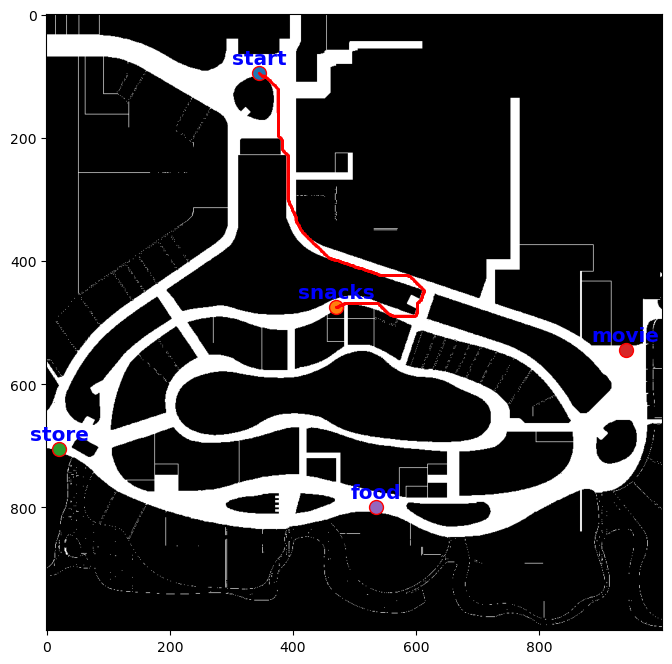

In [23]:
def a_star(start_id, goal_id, map_data):
    start = tuple(locations[start_id])
    goal = tuple(locations[goal_id])
    open_set = {start}
    came_from = {}
    g_score = {start: 0}
    f_score = {start: heuristic_function(start, goal)}
    
    obstacle_map = grid_map.copy()

    while open_set:
        current = min(open_set, key=lambda x: f_score[x])
        if current == goal:
            return reconstruct_path(came_from, goal)

        open_set.remove(current)
        
        for neighbor in get_neighbour(current, map_data, obstacle_map):
            cost = get_cost(neighbor[0] - current[0], neighbor[1] - current[1])
            tentative_g_score = g_score[current] + cost
            if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g_score
                f_score[neighbor] = tentative_g_score + heuristic_function(neighbor, goal)
                if neighbor not in open_set:
                    open_set.add(neighbor)

    return None

# Finding path from start to store
start_time = time.time()
path, total_distance = a_star('start', 'snacks', grid_map)

print("Run Time:", time.time() - start_time, "seconds")
print("Path steps is " + str(len(path)) + ", Distance is: " + str(total_distance))

visualize_path(path, grid_map_img, locations)

## 1.2 Implement Dijkstra
可以发现考虑步长的这个方案是可以实施的。

Run Time: 4.718070983886719 seconds
Path steps is 631, Distance is: 142.31800000000015


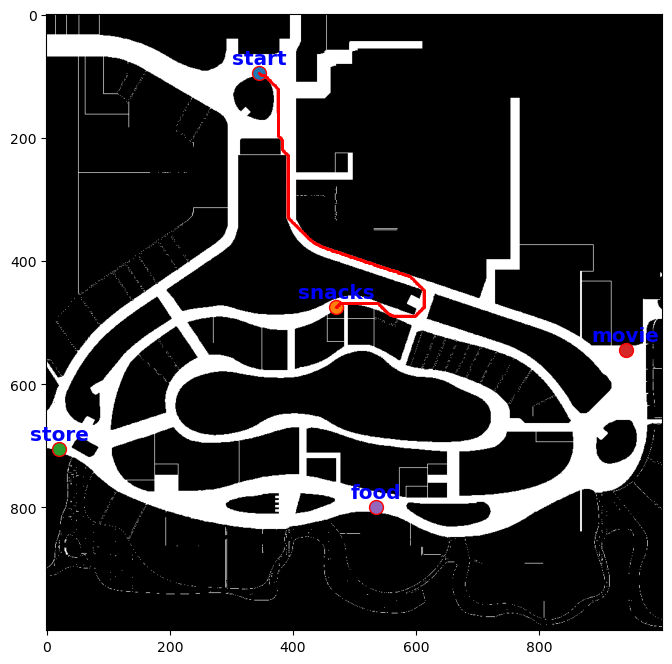

In [24]:
def dijkstra(start_id, goal_id, map_data):
    start = tuple(locations[start_id])
    goal = tuple(locations[goal_id])
    
    open_set = {start}
    came_from = {}
    g_score = {start: 0}
    
    obstacle_map = grid_map.copy()

    while open_set:
        current = min(open_set, key=lambda x: g_score[x])
        if current == goal:
            return reconstruct_path(came_from, current)

        open_set.remove(current)
        
        for neighbor in get_neighbour(current, map_data, obstacle_map):
            cost = get_cost(neighbor[0] - current[0], neighbor[1] - current[1])
            tentative_g_score = g_score[current] + cost
            if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g_score
                if neighbor not in open_set:
                    open_set.add(neighbor)

    return None

start_time = time.time()
path, total_distance = dijkstra('start', 'snacks', grid_map)

print("Run Time:", time.time() - start_time, "seconds")
print("Path steps is " + str(len(path)) + ", Distance is: " + str(total_distance))

visualize_path(path, grid_map_img, locations)

## 1.3 Implement Greedy Best First Search

Run Time: 0.9546151161193848 seconds
Path steps is 639, Distance is: 145.72200000000078


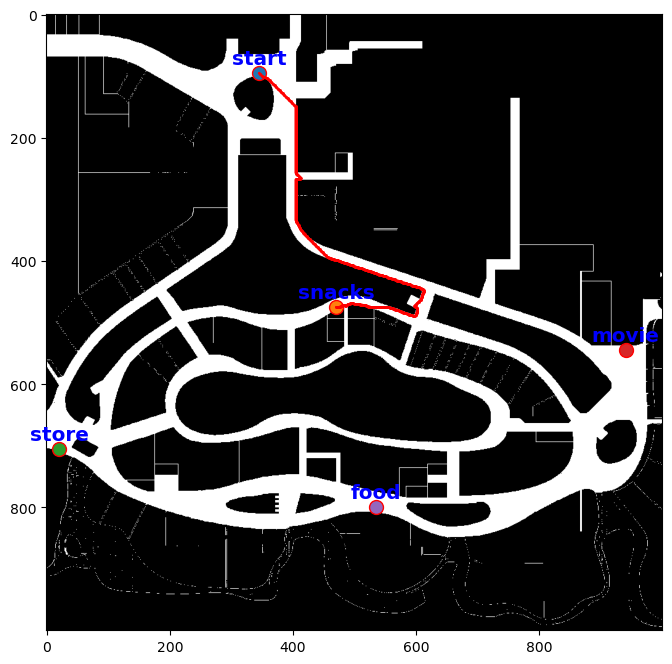

In [21]:
def greedy_best_first_search(start_id, goal_id, map_data):
    start = tuple(locations[start_id])
    goal = tuple(locations[goal_id])
    
    open_set = {start}
    came_from = {}
    f_score = {start: heuristic_function(start, goal)}
    
    obstacle_map = grid_map.copy()

    while open_set:
        current = min(open_set, key=lambda x: f_score[x])
        
        if current == goal:
            return reconstruct_path(came_from, current)

        open_set.remove(current)
        
        for neighbor in get_neighbour(current, map_data, obstacle_map):
            if neighbor not in f_score:
                came_from[neighbor] = current
                f_score[neighbor] = heuristic_function(neighbor, goal)
                if neighbor not in open_set:
                    open_set.add(neighbor)

    return None

start_time = time.time()
path, total_distance = greedy_best_first_search('start', 'snacks', grid_map)

print("Run Time:", time.time() - start_time, "seconds")
print("Path steps is " + str(len(path)) + ", Distance is: " + str(total_distance))

visualize_path(path, grid_map_img, locations)

## Calculate Distance Matrix
Calculate the distance between each node.

In [28]:
print(locations.keys())
locations_keys = locations.keys()
distance_df = pd.DataFrame(index=locations_keys, columns=locations_keys)
path_df = pd.DataFrame(index=locations_keys, columns=locations_keys)
total_start_time = time.time()
for location1 in locations_keys:
    for location2 in locations_keys:
        if location1 == location2:
            distance_df.loc[location1, location2] = 0
        elif pd.isna(distance_df.loc[location1, location2]):
            start_time = time.time()
            path, total_distance = dijkstra(location1, location2, grid_map)
            print("Path between " + location1 + " and " + location2 + ", Run Time:", time.time() - start_time, "seconds")
            print("Path steps is " + str(len(path)) + ", Distance is: " + str(total_distance))
            
            distance_df.loc[location1, location2] = total_distance
            distance_df.loc[location2, location1] = total_distance
            
            path_df.loc[location1, location2] = path
            reversed_path = path.copy()
            reversed_path.reverse()
            path_df.loc[location2, location1] = reversed_path
total_run_time = time.time() - total_start_time  
print("Total Run Time:", total_run_time, "seconds") 
distance_df

dict_keys(['start', 'snacks', 'store', 'movie', 'food'])
Path between start and snacks, Run Time: 11.316049814224243 seconds
Path steps is 631, Distance is: 142.31800000000015
Path between start and store, Run Time: 13.380346775054932 seconds
Path steps is 664, Distance is: 154.9039999999989
Path between start and movie, Run Time: 15.831950187683105 seconds
Path steps is 789, Distance is: 178.6739999999983
Path between start and food, Run Time: 24.670616149902344 seconds
Path steps is 983, Distance is: 223.04999999999836
Path between snacks and store, Run Time: 13.83309268951416 seconds
Path steps is 500, Distance is: 114.64200000000034
Path between snacks and movie, Run Time: 10.810060977935791 seconds
Path steps is 476, Distance is: 107.38200000000028
Path between snacks and food, Run Time: 19.75232982635498 seconds
Path steps is 594, Distance is: 133.27800000000005
Path between store and movie, Run Time: 24.371753931045532 seconds
Path steps is 964, Distance is: 209.24599999999813
P

,start,snacks,store,movie,food
start,0,142.318,154.904,178.674,223.05
snacks,142.318,0,114.642,107.382,133.278
store,154.904,114.642,0,209.246,110.79
movie,178.674,107.382,209.246,0,113.592
food,223.05,133.278,110.79,113.592,0


# Task 2

在Task2中，需要找到一条路径，这个路径从start开始，遍历四个商铺，最后回到start。由于前面已经计算了每个结点两两之间的关系，因此此处的问题简化为寻找一个最优的排列顺序。

## 2.1 Implement Brute Force

In [8]:
import itertools
import random

In [9]:
def visualize_circle_path(node_index_array, map_img, map_locations):
    plt.figure(figsize=(8, 8))
    plt.imshow(map_img, cmap='gray')
    plot_locations(map_locations, color='blue')
    colors = ['red', 'green', 'purple', 'orange', 'cyan', 'magenta', 'yellow']
    path_distance = 0
    for i in range(1, len(node_index_array)):
        path_array = path_df[node_index_array[i-1]][node_index_array[i]]
        path_distance += distance_df[node_index_array[i-1]][node_index_array[i]]
        x, y = zip(*path_array)
        color = colors[i % len(colors)]
        plt.plot(x, y, marker='o', color=color, markersize=1, linestyle='-')
    plt.show()
    return path_distance

('start', 'snacks', 'movie', 'food', 'store', 'start')
Total time for Brute Force: 0.0014431476593017578 seconds


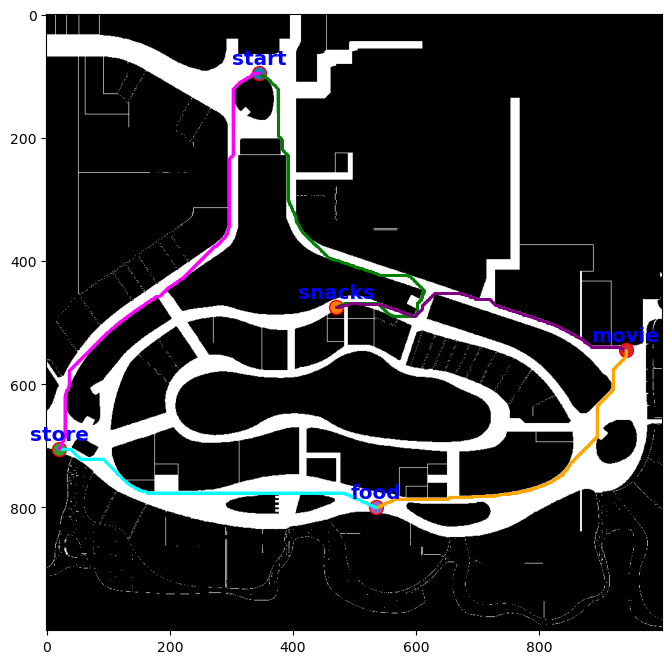

Total distance for Brute Force: 628.9859999999998


In [10]:
def brute_force():
    min_distance = float('inf')
    best_path = None
    
    remaining_nodes = [node for node in locations_keys if node != 'start']
    for perm in itertools.permutations(remaining_nodes):
        perm = ('start',) + perm + ('start',)
        path_distance = sum(distance_df[perm[i]][perm[i + 1]] for i in range(len(perm) - 1))
        if path_distance < min_distance:
            min_distance = path_distance
            best_path = perm

    return best_path

start_time = time.time()
brute_force_best_path = brute_force()
print(brute_force_best_path)
print("Total time for Brute Force:", time.time() - start_time, "seconds")
total_distance = visualize_circle_path(brute_force_best_path, grid_map_img, locations)
print("Total distance for Brute Force:", total_distance)

## 2.2 Implement Genetic Algorithm

['start', 'snacks', 'movie', 'food', 'store', 'start']
Total time for Genetic Algorithm: 0.2713930606842041 seconds


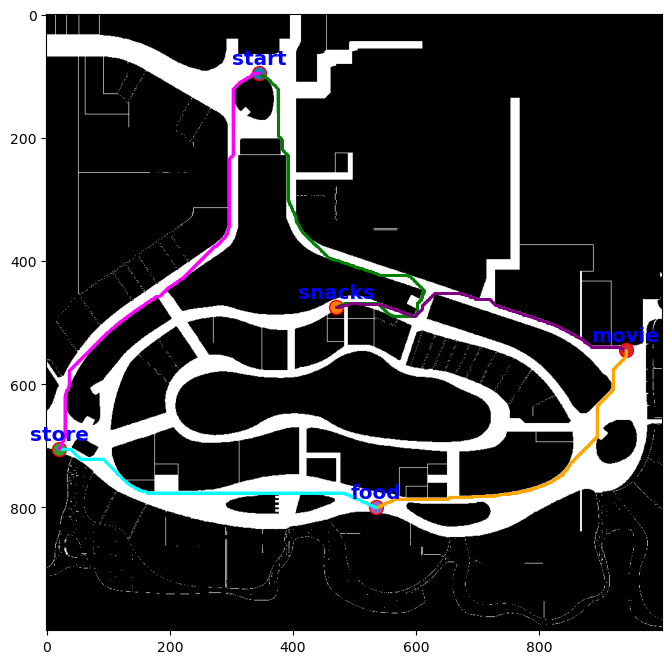

Total distance for Genetic Algorithm: 628.9859999999998


In [11]:
def genetic_algorithm():
    population_size = 100
    generations = 100
    mutation_rate = 0.1
    
    remaining_nodes = [node for node in locations_keys if node != 'start']

    def create_individual():
        return random.sample(remaining_nodes, len(remaining_nodes))

    def fitness(individual):
        path_distance = sum(distance_df[individual[i]][individual[i + 1]] for i in range(len(individual) - 1))
        path_distance += distance_df['start'][individual[0]]   # 从起点出发
        path_distance += distance_df[individual[-1]]['start']  # 回到起点
        return 1 / path_distance

    def crossover(parent1, parent2):
        crossover_point = random.randint(1, len(remaining_nodes) - 1)
        child1 = parent1[:crossover_point] + [node for node in parent2 if node not in parent1[:crossover_point]]
        child2 = parent2[:crossover_point] + [node for node in parent1 if node not in parent2[:crossover_point]]
        return child1, child2

    def mutate(individual):
        if random.random() < mutation_rate:
            idx1, idx2 = random.sample(range(len(remaining_nodes)), 2)
            individual[idx1], individual[idx2] = individual[idx2], individual[idx1]
        return individual

    population = [create_individual() for _ in range(population_size)]

    for _ in range(generations):
        population = sorted(population, key=fitness, reverse=True)
        parents = population[:population_size // 2]
        offspring = []

        for _ in range(population_size // 2):
            parent1, parent2 = random.sample(parents, 2)
            child1, child2 = crossover(parent1, parent2)
            offspring.append(mutate(child1))
            offspring.append(mutate(child2))

        population = parents + offspring

    best_individual = max(population, key=fitness)
    return best_individual

start_time = time.time()
genetic_best_path = genetic_algorithm()
genetic_best_path.append('start')
genetic_best_path.insert(0, 'start')
print(genetic_best_path)
print("Total time for Genetic Algorithm:", time.time() - start_time, "seconds")
total_distance = visualize_circle_path(genetic_best_path, grid_map_img, locations)
print("Total distance for Genetic Algorithm:", total_distance)